# Bird Image Classification Project

## Imports and Data Loading

In [1]:
pip install evaluate

^C
Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/opt/anaconda3/lib/python3.12/site-packages/pip/__main__.py", line 24, in <module>
    sys.exit(_main())
             ^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/pip/_internal/cli/main.py", line 79, in main
    return command.main(cmd_args)
           ^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/pip/_internal/cli/base_command.py", line 101, in main
    return self._main(args)
           ^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/pip/_internal/cli/base_command.py", line 236, in _main
    self.handle_pip_version_check(options)
  File "/opt/anaconda3/lib/python3.12/site-packages/pip/_internal/cli/req_command.py", line 177, in handle_pip_version_check
    session = self._build_session(
              ^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages

In [ ]:
pip install datasets

In [ ]:
# Imports
from datasets import load_dataset
import evaluate
from glob import glob
import imagesize
import math
import numpy as np
import os
import pandas as pd
from pathlib import Path
from PIL import Image
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from transformers import create_optimizer, DefaultDataCollator, EarlyStoppingCallback, pipeline, TFViTForImageClassification as ViTForImageClassification, ViTImageProcessor
from transformers.keras_callbacks import KerasMetricCallback, PushToHubCallback

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define path to data directory
data_dir = os.path.join('drive', 'MyDrive', 'ConcordiaBootcamp', 'Data', 'birds')

In [ ]:
# Load dataset
dataset = load_dataset(path=data_dir)

Resolving data files:   0%|          | 0/3208 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/100 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/100 [00:00<?, ?it/s]

## EDA

In [ ]:
# Get subfolders
subfolders = [d.name for d in Path(data_dir).iterdir() if d.is_dir()]
subfolders

['images to predict', 'test', 'train', 'valid']

In [ ]:
# Get dataset structure
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 3208
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 100
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 100
    })
})

In [ ]:
# Get total number of images in dataset
complete_list = list(Path(data_dir).glob('*/*/*.jpg'))
nb_images = len(complete_list)
nb_images

3408

In [ ]:
# Get number of images to predict
pred_dir = os.path.join(data_dir, 'images to predict')
pred_img_paths = list(Path(pred_dir).glob('*.jpg'))
pred_size = len(pred_img_paths)
pred_size

6

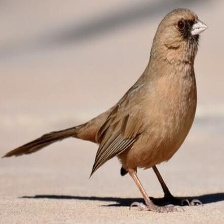

In [ ]:
# Load one image from dataset at random
np.random.seed(42)
random_set = np.random.choice(['train', 'validation', 'test'])
random_item = np.random.choice(dataset[random_set])
display(random_item['image'])

In [ ]:
# Get size of that image
random_item['image'].size

(224, 224)

## Data Preprocessing

In [ ]:
# Load image processor
checkpoint = 'google/vit-base-patch16-224'
image_processor = ViTImageProcessor.from_pretrained(checkpoint)
image_processor

In [ ]:
# Define size for input data
size = (image_processor.size['height'], image_processor.size['width'])

In [ ]:
# Define train dataset
train_data_augmentation = keras.Sequential(
  [
    keras.layers.RandomCrop(size[0], size[1]),
    keras.layers.Rescaling(scale=1.0/127.5, offset=-1),
    keras.layers.RandomFlip('horizontal'),
    keras.layers.RandomRotation(factor=0.02),
    keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2),
  ],
  name='train_data_augmentation',
)

In [ ]:
# Define validation dataset
val_data_augmentation = keras.Sequential(
    [
        keras.layers.CenterCrop(size[0], size[1]),
        keras.layers.Rescaling(scale=1.0/127.5, offset=-1),
    ],
    name='val_data_augmentation',
)

In [ ]:
# Define test dataset
test_data = keras.Sequential(
    [
        keras.layers.Rescaling(scale=1.0/127.5, offset=-1),
    ],
    name='test_data',
)

In [ ]:
# Create functions to apply appropriate transformations
def convert_to_tf_tensor(image: Image):
  np_image = np.array(image)
  tf_image = tf.convert_to_tensor(np_image)

  return tf.expand_dims(tf_image, 0)


def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    images = [
        train_data_augmentation(convert_to_tf_tensor(image.convert("RGB"))) for image in example_batch['image']
    ]
    example_batch['pixel_values'] = [tf.transpose(tf.squeeze(image)) for image in images]
    return example_batch


def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    images = [
        val_data_augmentation(convert_to_tf_tensor(image.convert('RGB'))) for image in example_batch['image']
    ]
    example_batch['pixel_values'] = [tf.transpose(tf.squeeze(image)) for image in images]
    return example_batch

def preprocess_test(example_batch):
  """Apply val_transforms across a batch."""
  images = [
      test_data(convert_to_tf_tensor(image.convert('RGB'))) for image in example_batch['image']
  ]
  example_batch['pixel_values'] = [tf.transpose(tf.squeeze(image)) for image in images]
  return example_batch

In [ ]:
# Apply transformations
dataset['train'].set_transform(preprocess_train)
dataset['validation'].set_transform(preprocess_val)
dataset['test'].set_transform(preprocess_test)

In [ ]:
# Define data collator
data_collator = DefaultDataCollator(return_tensors="tf")

## Data Modeling

### Load pre-trained model

In [ ]:
# Create mapping for categories
labels = dataset['train'].features['label'].names
label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [ ]:
label2id

In [ ]:
id2label

In [ ]:
pip install huggingface_hub[hf_xet]

In [ ]:
# Initialize the model
model = ViTForImageClassification.from_pretrained(checkpoint)

All PyTorch model weights were used when initializing TFViTForImageClassification.

All the weights of TFViTForImageClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.


AMERICAN COOT


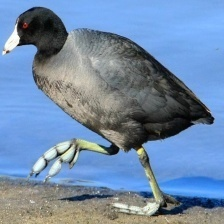

ALEXANDRINE PARAKEET


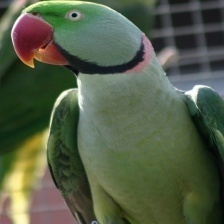

ALTAMIRA YELLOWTHROAT


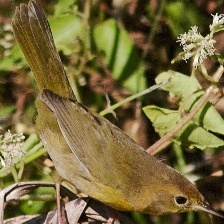

ALTAMIRA YELLOWTHROAT


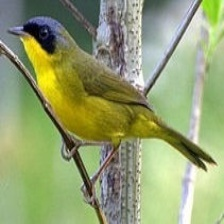

ALBATROSS


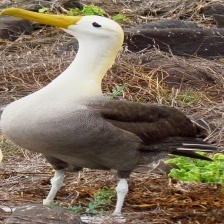

In [ ]:
# Get some images from the validation set
random.seed(42)
random_dataset = np.random.choice(dataset['validation'], 5, replace=False)

preds = []
for item in random_dataset:
  preds.append({
      'image': item['image'],
      'actual': id2label[str(item['label'])]
  })

preds_df = pd.DataFrame(preds)

for index, row in preds_df.iterrows():
  print(row['actual'])
  display(row['image'])

In [ ]:
# Make a prediction
inputs = image_processor(images=images, return_tensors="tf")
outputs = model(**inputs)
logits = outputs.logits
logits

<tf.Tensor: shape=(5, 1000), dtype=float32, numpy=
array([[ 0.49040353,  1.1180147 , -0.13618383, ..., -0.04706587,
         0.7218156 , -0.90449977],
       [ 1.492529  , -0.5306383 , -0.5379988 , ..., -0.7598639 ,
         1.0595863 ,  0.04111214],
       [ 1.5516258 ,  0.1861698 , -0.41624054, ...,  0.937194  ,
         1.04934   , -0.07041159],
       [ 1.3130026 , -0.07351205, -0.79219365, ...,  0.37184408,
         1.1129366 , -0.4788346 ],
       [ 0.24832346, -0.11170052,  0.5124888 , ..., -0.9147028 ,
         0.41021076, -1.3748181 ]], dtype=float32)>

In [ ]:
predicted = []

for logit in logits:
  predicted_class_idx = logit.numpy().argmax(-1).item()
  predicted.append(model.config.id2label[predicted_class_idx])

preds_df.insert(1, 'predicted' , pd.Series(predicted))
preds_df[['predicted', 'actual']]

Predicted class: American coot, marsh hen, mud hen, water hen, Fulica americana
Predicted class: macaw
Predicted class: indigo bunting, indigo finch, indigo bird, Passerina cyanea
Predicted class: jacamar
Predicted class: albatross, mollymawk


### Fit model with bird categories

In [ ]:
# Load accuracy to evaluate model
accuracy = evaluate.load("accuracy")

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
# Define optimizer
batch_size = 16
num_epochs = 5
num_train_steps = len(dataset['train']) * num_epochs
learning_rate = 3e-5
weight_decay_rate = 0.01

optimizer, lr_schedule = create_optimizer(
    init_lr=learning_rate,
    num_train_steps=num_train_steps,
    weight_decay_rate=weight_decay_rate,
    num_warmup_steps=0,
)

In [ ]:
# Load model with label mappings
model = ViTForImageClassification.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTForImageClassification: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing TFViTForImageClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFViTForImageClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.
Some weights of TFViTForImageClassification were not initialized from the model checkpoint are newly initialize

In [ ]:
model.summary()

In [ ]:
# Convert datasets to tf.data.Dataset
tf_train_dataset = dataset['train'].to_tf_dataset(
    columns='pixel_values', label_cols='label', shuffle=True, batch_size=batch_size, collate_fn=data_collator
)
tf_val_dataset = dataset['validation'].to_tf_dataset(
    columns='pixel_values', label_cols='label', shuffle=True, batch_size=batch_size, collate_fn=data_collator
)
tf_test_dataset = dataset['test'].to_tf_dataset(
    columns='pixel_values', label_cols='label', shuffle=True, batch_size=batch_size, collate_fn=data_collator
)

In [ ]:
# Configure the model for training
loss = SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss)

In [ ]:
# Define callbacks from transformers
metric_callback = KerasMetricCallback(metric_fn=compute_metrics, eval_dataset=tf_val_dataset, batch_size=batch_size)

push_to_hub_callback = PushToHubCallback(
    output_dir='bird_classifier',
    tokenizer=image_processor,
    save_strategy='no',
)

callbacks = [metric_callback, push_to_hub_callback]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
/content/bird_classifier is already a clone of https://huggingface.co/nadpierre/bird_classifier. Make sure you pull the latest changes with `repo.git_pull()`.


In [ ]:
# Fit model
model.fit(tf_train_dataset, validation_data=tf_val_dataset, epochs=num_epochs, callbacks=callbacks)

Epoch 1/5
 48/201 [======>.......................] - ETA: 1:52:15 - loss: 2.2935

### Fine tune model

### Final Model

## Make predictions

## End